In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import datetime
import calendar

In [2]:
tweets_df = pd.read_csv('Tweets.csv')
delays_df = pd.read_csv('Delay_Airlines.csv')
weekdays = calendar.day_name

tweets_df['timestamp'] = pd.to_datetime(tweets_df['tweet_created'],format= '%Y-%m-%d %H:%M:%S')

## Airline popularity

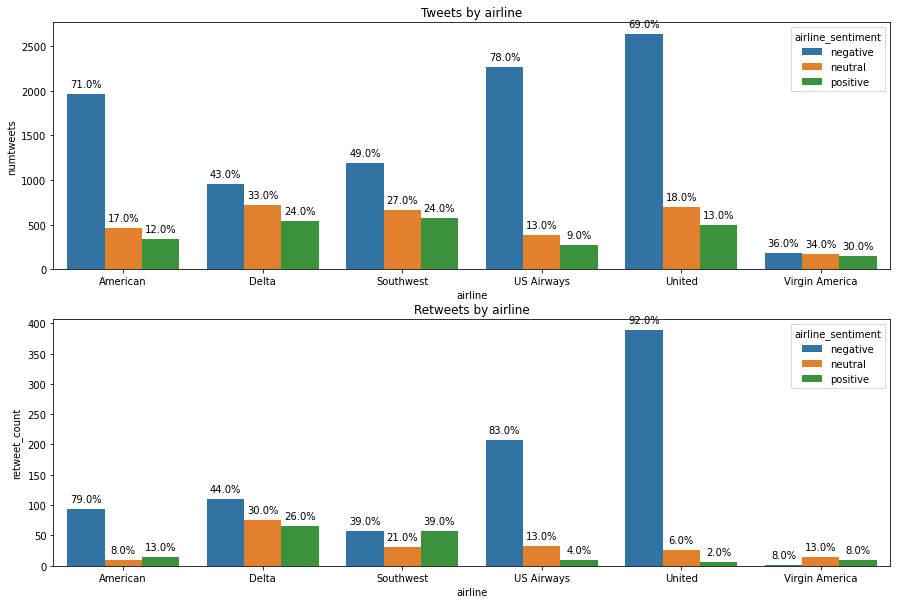

In [3]:
airline_popularity = tweets_df.groupby(['airline', 'airline_sentiment']).agg({
    'tweet_id': 'count',
    'retweet_count': 'sum'
}).reset_index()

_airline_tweets = tweets_df.groupby('airline').agg({
    'tweet_id': 'count',
    'retweet_count': 'sum'
}).reset_index()

_airline_tweets.rename(columns={
    'tweet_id': 'numtweets_by_airline',
    'retweet_count': 'retweet_count_by_airline'
}, inplace=True)
airline_popularity.rename(columns={'tweet_id': 'numtweets'}, inplace=True)

airline_popularity = airline_popularity.merge(_airline_tweets, on='airline')
airline_popularity['numtweets_percentage'] = 100 * airline_popularity[
    'numtweets'] / airline_popularity['numtweets_by_airline']
airline_popularity['retweet_count_percentage'] = 100 * airline_popularity[
    'retweet_count'] / airline_popularity['retweet_count_by_airline']

airline_popularity.sort_values(['airline', 'numtweets', 'retweet_count'],
                               ascending=[True, False, False],
                               inplace=True)

plotsize = (15, 10)
fig, axs = plt.subplots(2, figsize=plotsize)

sns.barplot(x="airline",
            y="numtweets",
            hue="airline_sentiment",
            data=airline_popularity,
            ax=axs[0]).set_title('Tweets by airline')
sns.barplot(x="airline",
            y="retweet_count",
            hue="airline_sentiment",
            data=airline_popularity,
            ax=axs[1]).set_title('Retweets by airline')

for i, p in enumerate(axs[0].patches):
    val = airline_popularity[
        abs(airline_popularity['numtweets'] -
            p.get_height()) < 0.01]['numtweets_percentage'].values[0]
    axs[0].annotate(str(np.round(val)) + "%",
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center',
                    va='center',
                    textcoords='offset points',
                    xytext=(0, 10))

for i, p in enumerate(axs[1].patches):
    val = airline_popularity[
        abs(airline_popularity['retweet_count'] -
            p.get_height()) < 0.01]['retweet_count_percentage'].values[0]
    axs[1].annotate(str(np.round(val)) + "%",
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center',
                    va='center',
                    textcoords='offset points',
                    xytext=(0, 10))

## Tweets by sentiment and day

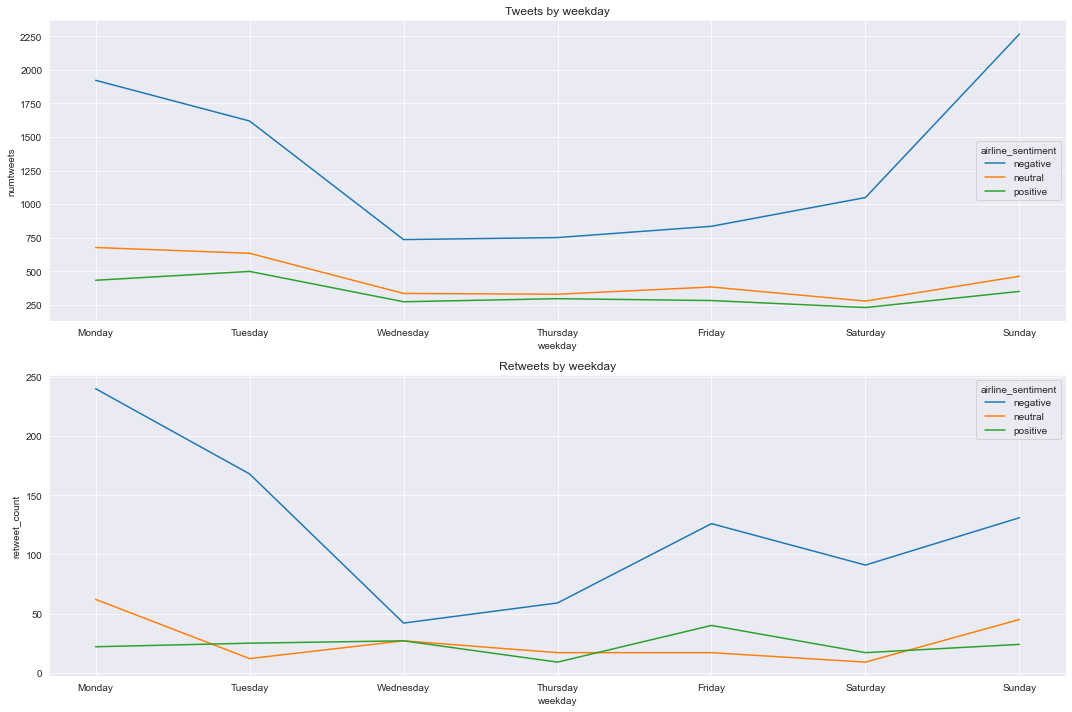

In [4]:
tweets_df['weekday'] = tweets_df['timestamp'].apply(lambda x: x.weekday())

weekday_tweets = tweets_df.groupby(['weekday', 'airline_sentiment']).agg({
    'tweet_id': 'count',
    'retweet_count': 'sum'
}).reset_index()
weekday_tweets.sort_values('weekday', inplace=True)
weekday_tweets['weekday'] = weekday_tweets['weekday'].apply(lambda x: weekdays[x])
weekday_tweets.rename(columns={'tweet_id': 'numtweets'}, inplace=True)

sns.set_style("darkgrid")
plotsize = (15, 10)
fig, axs = plt.subplots(2, figsize=plotsize)

sns.lineplot(x="weekday",
            y="numtweets",
            hue="airline_sentiment",
            data=weekday_tweets,
            ax=axs[0]).set_title('Tweets by weekday')
sns.lineplot(x="weekday",
            y="retweet_count",
            hue="airline_sentiment",
            data=weekday_tweets,
            ax=axs[1]).set_title('Retweets by weekday')
plt.tight_layout()

## Tweets by sentiment and hour

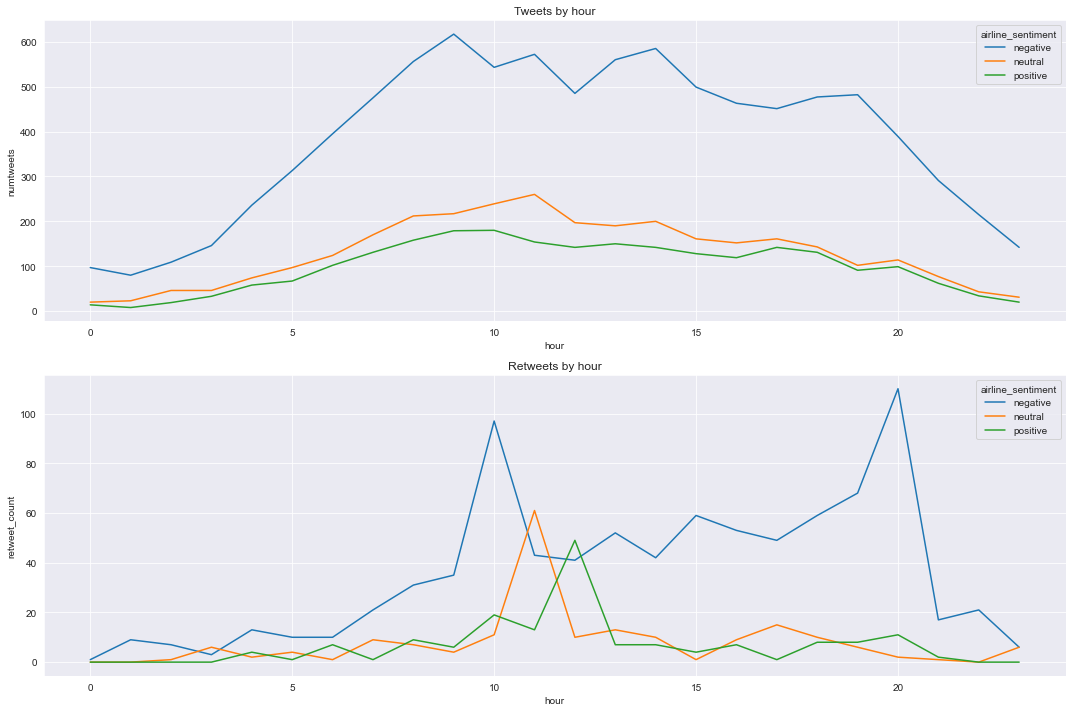

In [5]:
tweets_df['hour'] = tweets_df['timestamp'].apply(lambda x: x.hour)

hourly_tweets = tweets_df.groupby(['hour', 'airline_sentiment']).agg({
    'tweet_id': 'count',
    'retweet_count': 'sum'
}).reset_index()
hourly_tweets.sort_values('hour', inplace=True)
hourly_tweets.rename(columns={'tweet_id': 'numtweets'}, inplace=True)


sns.set_style("darkgrid")
plotsize = (15, 10)
fig, axs = plt.subplots(2, figsize=plotsize)


sns.lineplot(x="hour",
            y="numtweets",
            hue="airline_sentiment",
            data=hourly_tweets,
            ax=axs[0]).set_title('Tweets by hour')
sns.lineplot(x="hour",
            y="retweet_count",
            hue="airline_sentiment",
            data=hourly_tweets,
            ax=axs[1]).set_title('Retweets by hour')
plt.tight_layout()

## Correlation between tweets and cancelled flights.

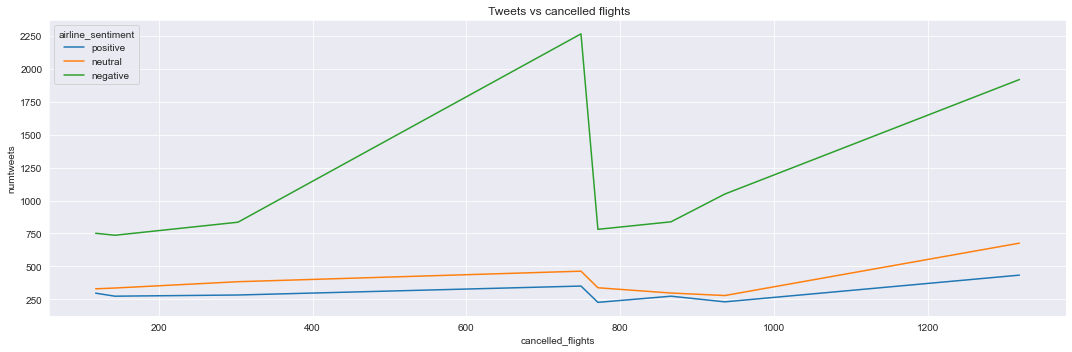

In [9]:
tweets_df['date'] = pd.to_datetime(tweets_df['tweet_created'],format= '%Y-%m-%d %H:%M:%S').dt.date
delays_df['FL_DATE'] = pd.to_datetime(delays_df['FL_DATE'],format= '%Y-%m-%d').dt.date
delays_df = delays_df[['FL_DATE', 'CANCELLED']]

tweets_grouped = tweets_df.groupby(['date', 'airline_sentiment']).agg({
    'tweet_id': 'count',
    'retweet_count': 'sum'
}).reset_index()

# 2015-02-16 has missing Tweets data for full day (there are only a few tweets comparing with other days)
tweets_grouped = tweets_grouped[tweets_grouped['date'] > datetime.date(2015, 2, 16)]

delays_grouped = delays_df.groupby(['FL_DATE']).agg({
    'CANCELLED': 'sum'
}).reset_index()

_tweets_totals = tweets_df.groupby('date').agg({
    'tweet_id': 'count',
    'retweet_count': 'sum'
}).reset_index()
_tweets_totals.rename(columns={'tweet_id': 'total_numtweets', 'retweet_count': 'total_retweet_count'}, inplace=True)

tweets_grouped = tweets_grouped.merge(_tweets_totals, on='date')

df = tweets_grouped.merge(delays_grouped, left_on='date', right_on='FL_DATE')
df.rename(columns={'tweet_id': 'numtweets', 'CANCELLED': 'cancelled_flights'}, inplace=True)
df.sort_values(['cancelled_flights', 'numtweets'], inplace=True)

sns.set_style("darkgrid")
plotsize = (15, 5)
fig, axs = plt.subplots(1, figsize=plotsize)

sns.lineplot(x="cancelled_flights",
                y="numtweets",
                hue="airline_sentiment",
                data=df,
                ax=axs).set_title(f' Tweets vs cancelled flights')   
plt.tight_layout()

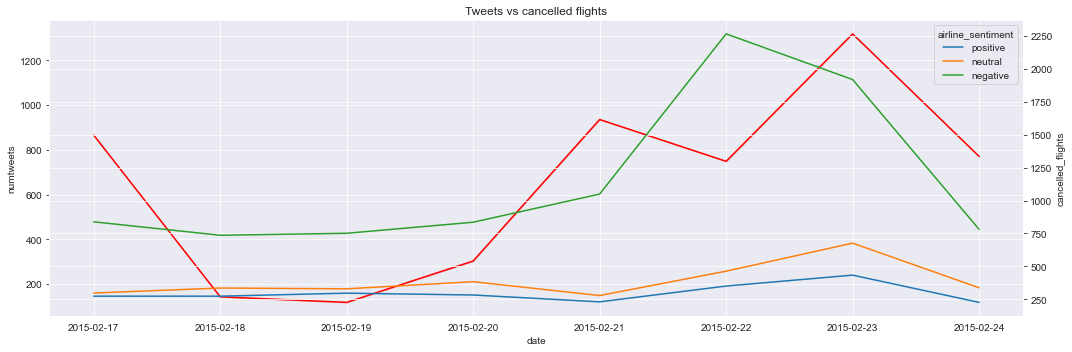

In [7]:
sns.set_style("darkgrid")
plotsize = (15, 5)
fig, ax1 = plt.subplots(1, figsize=plotsize)

ax2 = ax1.twinx() 

sns.lineplot(x="date",
                y="cancelled_flights",
                data=df,
                ax=ax1,
                color='r',
                legend='brief').set_title(f'Tweets vs cancelled flights')   

sns.lineplot(x="date",
                y="numtweets",
                hue='airline_sentiment',
                data=df,
                ax=ax2)

ax1.set_ylabel('numtweets')
ax2.set_ylabel('cancelled_flights')
plt.tight_layout()

Normal values
p-value: cancelled_flights    0.001025
dtype: float64
p-mse_total: 1629105.625
                                 OLS Regression Results                                
Dep. Variable:              numtweets   R-squared (uncentered):                   0.806
Model:                            OLS   Adj. R-squared (uncentered):              0.778
Method:                 Least Squares   F-statistic:                              28.99
Date:                Sun, 20 Jun 2021   Prob (F-statistic):                     0.00103
Time:                        23:02:50   Log-Likelihood:                         -62.016
No. Observations:                   8   AIC:                                      126.0
Df Residuals:                       7   BIC:                                      126.1
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                        coe

C:\Users\tiendeo\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


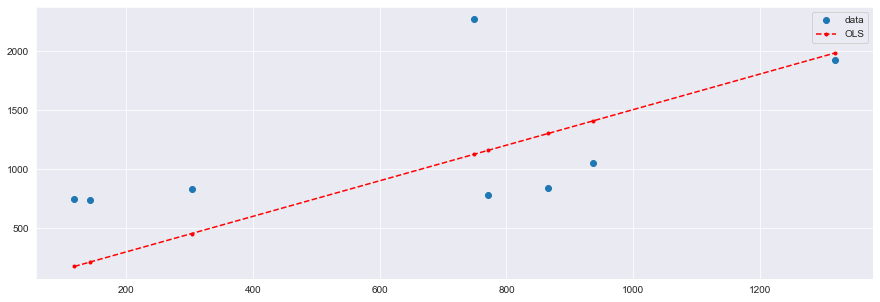

In [8]:
import statsmodels.api as sm

_ols_df = df.copy()

X = _ols_df[_ols_df['airline_sentiment'] == 'negative']['cancelled_flights']
y = _ols_df[_ols_df['airline_sentiment'] == 'negative']['numtweets']

model = sm.OLS(y, X)
results = model.fit()

print("Normal values")
print(f"p-value: {results.pvalues}")
print(f"p-mse_total: {results.mse_total}")
print(results.summary())

fig, ax = plt.subplots(figsize=(15,5))

ax.plot(X, y, 'o', label="data")
ax.plot(X, results.fittedvalues, 'r--.', label="OLS")
ax.legend(loc='best');
